In [4]:
import matplotlib.pyplot as plt
import os

import pandas as pd

In [9]:
path_results = './demo'
path_results_10K = './demo_10K'

In [10]:
def plot_results(path):
    
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111)
    for res in [f for f in os.listdir(path) if ((f[0]=='0'))]:
        title = res.split('scores_')[1]
        df_res = pd.read_csv(os.path.join(path, res))
        plt.plot(df_res.episode, df_res.score, marker='+', label = title)
    
    ax.hlines(13, 0, len(df_res.episode)*20, 'k', linestyle=':')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend()


## Learning Algorithm

#### Description of the algorithm

The learning algorithm is a **double deep Q-learning** algorithm using a **dueling network** and a **prioritized experience buffer**.
The target network is updated through soft updates.

The first versions of the agent were classic Deep Q-learning and iterativly the improvement were implemented, first the double DQL then the dueling network and finaly the prioritized experience buffer, in order to gain insights on the betterment of each method.<br>
Minor adjustments of the hyperparameters were made along the way to better suits the methods implemented, such as augmenting the rate of target network updates for double DQN.

The impact of the different improvments were subtle and the first results of the first experimentations were unclear as show by the performances displayed below.

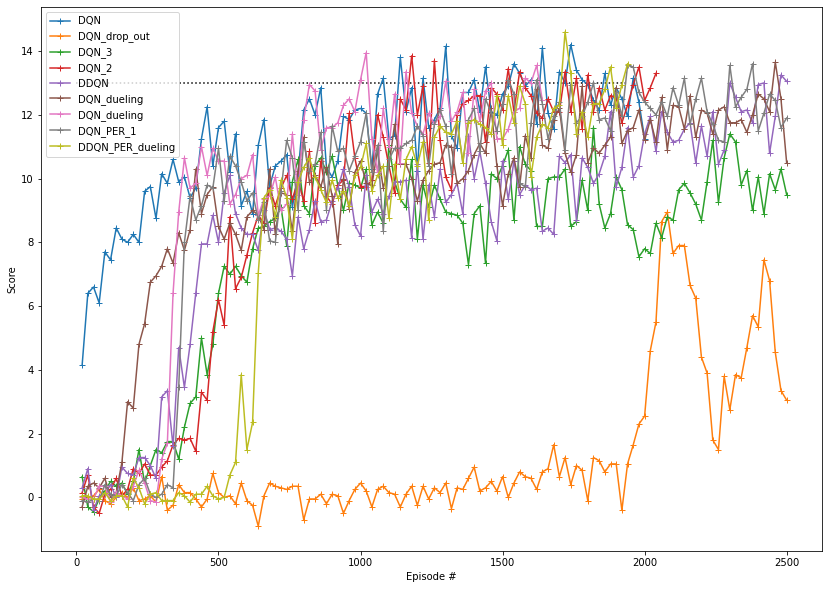

In [5]:
plot_results(path_results)

The improvments provided were more noticeable for a longer period of training, especally for the prioritized experience replay.

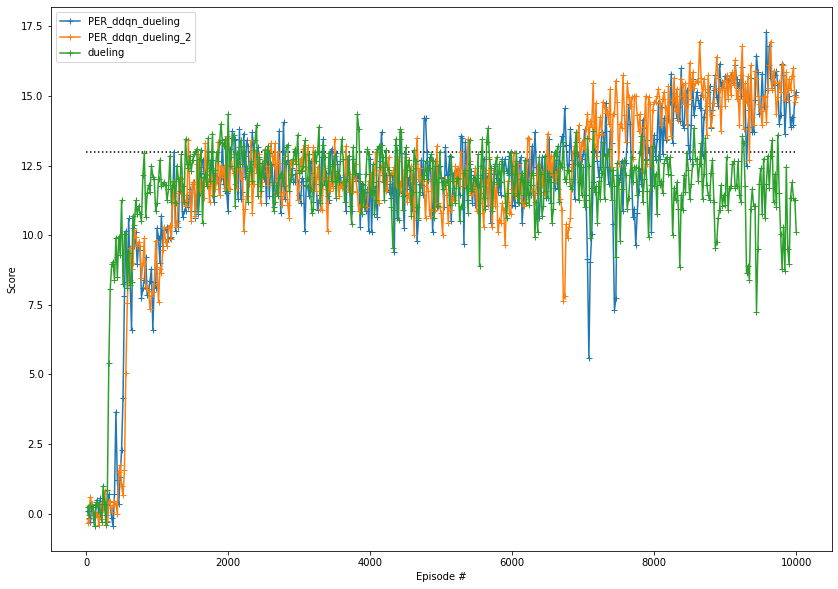

In [11]:
plot_results(path_results_10K)

#### Network model architecture

The dueling Q-network is composed of a common fully connected layer of size 64.<br>
The computation of the state value is obtain throught the use of two fully connected layers of 64 units.<br>
Similarly two fully connected layers are used to compute the advantage values.<br>
Finally the Q-value is computed by adding the state value and the the deviation of the advantage values from their mean.<br>

Experiments were made by adding drop out between fully connected layers and adding a softmax at the end of the network but the results were worse in each cases. The cardinality of the layers were choosen to be power of two as often in the cases I have study. There is a lot of room for improvment in the architecture ofthe network.

#### Choosen hyperparameters

- $\epsilon $ *epsilon* : from .25 to .01 with a decay of .992. I noticed that often the agent was using only one turn (left or right) so I increase the odds of random actions while respected the GLIE paradigm. <br>
- $\gamma $ *gamma* : .99 usual value of the discount factor.
- $\alpha $ *learning rate* : 0.0001 slightly lower value for a learning rate.
- $\tau $ *tau* : .15 the soft update of the target network parameter had a huge impact on the learning and add t be increase from .001 to work with the double DQL.<br>
- $\beta$ *beta* : from .4 to 1 in 800 iterations. For a target of ~1800 episodes, the increase of beta was design to occur for half the training. Th aims of this parameter is to gradually emphasis the prioritized experience during the learning.<br>
- *buffer size*: 10_000 the original value was kept.
- *batch_size*: 64 the original value was kept. In order to learn faster this hyperparameter was up to 128.
- *update every*: 10, this parameter tell the agent every 10 actions (if the buffer size is large enough). In order to learn faster this hyperparameter was up to 5.


## Plot of the rewards

The best result was **952 episodes** to solve the environment as displayed below.

Environnement solved in 952 episodes with score 13.03 over last 100 episodes!


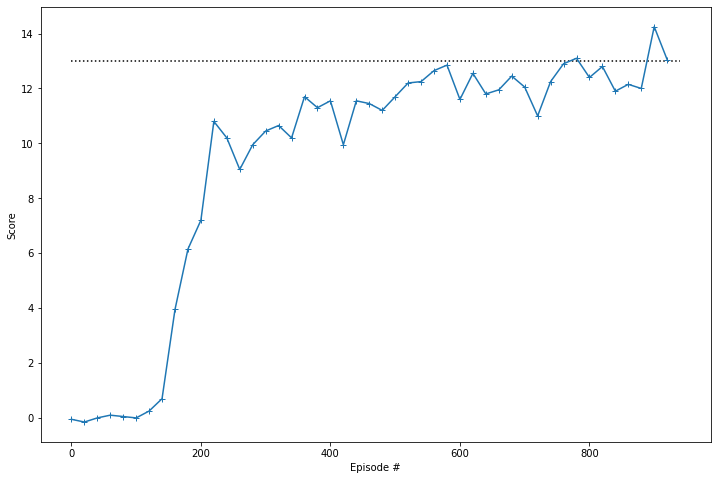

Wall time: 1h 4min 59s


In [10]:
%%time

_model_suffix = '' # specific model name for saving

AVERAGE_PASS_ENV = 100 # The score to pass has to be average on the last x episodes
SCORE_TO_PASS = 13

AVERAGE_ON_RECORD = 20
N_EPISODES = 2_500

cnt_record = 0
environment_solved = False
scores_record = deque()
scores_window = deque(maxlen=max(AVERAGE_ON_RECORD, AVERAGE_PASS_ENV))

for i in range(1, N_EPISODES + 1):
    
    if environment_solved:
        break
    # reset the environment and get the initial state
    env_info = env.reset(train_mode=True)[brain_name] 
    state = env_info.vector_observations[0]           
    score = 0                                         
    
    while True:
        
        # select an action
        action = agent.act(state)                     
        
        # send the action to the environment
        env_info = env.step(action)[brain_name]   
        # get the next state
        next_state = env_info.vector_observations[0] 
        # get the reward
        reward = env_info.rewards[0]  
         # see if episode has finished
        done = env_info.local_done[0]                 
        
        # save the experience and decide to learn or to continue interacting
        agent.step(state, action, reward, next_state, done) 
        
        # update the score
        score += reward                                
        state = next_state
        
        # Record score, check if the environment is solved and escape the loop.
        if done:                                       
            
            scores_window.append(score)
            cnt_record += 1
            
            # Record the averaged score when needed
            if cnt_record % AVERAGE_ON_RECORD == 0:
                score_averaged = np.mean(list(scores_window)[-AVERAGE_ON_RECORD:])
                scores_record.append(score_averaged)
                cnt_record = 0
                print(f"\rEpisode {i} Score: {score_averaged}", end='\r')
            
            # Check if the environnment is solved
            if len(scores_window) >= AVERAGE_PASS_ENV :
                score_averaged = np.mean(list(scores_window)[-AVERAGE_PASS_ENV:])
                if score_averaged > SCORE_TO_PASS:
                    environment_solved = True
                    print(f"\rEnvironnement solved in {i} episodes with score {score_averaged} over last {AVERAGE_PASS_ENV} episodes!")
                    now = datetime.now()
                    modelname = f'{str(now.month).zfill(2)}_{str(now.day).zfill(2)}_{now.hour}h{now.minute}_Qnet{_model_suffix}'
                    torch.save(agent.QNet_local.state_dict(), os.path.join(path_model, fr'{modelname}.pth'))
                    
            break
            
# plot the scores
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_record))*AVERAGE_ON_RECORD, scores_record, marker='+')
ax.hlines(13, 0, len(scores_record)*AVERAGE_ON_RECORD, 'k', linestyle=':')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Ideas for Future Work

 - The hyperparameters tuning is a very time-consuming process and large improvments must be possible by following this path. The lack of method made this search complicated and worrying.
 - There is a lot of improvements in the Q-network architecture as a lot of possible architecture are conceivable. The implementation is also defective as it is not completely parameterizable as for instance the number of layers is not parametrizeable.
 - Some experiments can also be conducted on the solver although the reward is less certain.
 - It must be interesting to test the more advanced techniques of the later part of the course in that use case.